Unsupervised Machine Learning

A case study of Amazon Customer Reviews

Amazon, as a leading e-commerce platform, receives millions of product
reviews that provide critical feedback on user experiences. These reviews
are not just ratings; they are rich with textual data revealing sentiments,
satisfaction levels, complaints, and suggestions.
In this project, we aim to uncover key insights from Amazon's user reviews
of digital software products to better understand:

How users feel about Amazon services and products.

Which aspects they like or dislike the most.

How user sentiment and satisfaction have evolved over time.

Which issues are most commonly raised in negative feedback.

How loyal and likely users are to recommend Amazon based on Net
Promoter Score (NPS).

In [41]:
# 1. Install required libraries (only run once)
# !pip install gensim nltk scikit-learn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  #(visualization library (Static))
import seaborn as sns            # visualizationlibrary (dynamic)
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score,classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import nltk
from nltk.corpus import stopwords
import re
import string
nltk.download('stopwords')



from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# Step 2: Import dataset

df = pd.read_csv('/content/amazon_reviews_data.csv')

In [43]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,8/31/2015
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,8/31/2015
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,8/31/2015
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,8/31/2015
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,8/31/2015


In [44]:
df.shape

(70663, 15)

In [45]:
#Quick summary and statistics

df.shape

(70663, 15)

In [46]:
df.isna().sum()

,0
marketplace,0
customer_id,18
review_id,23
product_id,32
product_parent,34
product_title,36
product_category,39
star_rating,42
helpful_votes,42
total_votes,42


In [47]:
df = df.dropna()

In [48]:
df.isnull().sum()

,0
marketplace,0
customer_id,0
review_id,0
product_id,0
product_parent,0
product_title,0
product_category,0
star_rating,0
helpful_votes,0
total_votes,0


In [49]:
df.shape

(70611, 15)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70611 entries, 0 to 70661
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        70611 non-null  object
 1   customer_id        70611 non-null  object
 2   review_id          70611 non-null  object
 3   product_id         70611 non-null  object
 4   product_parent     70611 non-null  object
 5   product_title      70611 non-null  object
 6   product_category   70611 non-null  object
 7   star_rating        70611 non-null  object
 8   helpful_votes      70611 non-null  object
 9   total_votes        70611 non-null  object
 10  vine               70611 non-null  object
 11  verified_purchase  70611 non-null  object
 12  review_headline    70611 non-null  object
 13  review_body        70611 non-null  object
 14  review_date        70611 non-null  object
dtypes: object(15)
memory usage: 8.6+ MB


In [51]:
import pandas as pd

# Assuming your DataFrame is named df
df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce')
df['helpful_votes'] = pd.to_numeric(df['helpful_votes'], errors='coerce')
df['total_votes'] = pd.to_numeric(df['total_votes'], errors='coerce')
df['customer_id'] = pd.to_numeric(df['customer_id'], errors='coerce')

In [52]:
# Option 1: Drop rows with NaNs
df.dropna(subset=['star_rating', 'helpful_votes', 'total_votes', 'customer_id'], inplace=True)

# Option 2: Fill NaNs with 0 (or another appropriate default)
# df[['star_rating', 'helpful_votes', 'total_votes', 'customer_id']] = \
#     df[['star_rating', 'helpful_votes', 'total_votes', 'customer_id']].fillna(0)

In [53]:
print(df.dtypes)

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent        object
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70611 entries, 0 to 70661
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marketplace        70611 non-null  object 
 1   customer_id        70611 non-null  int64  
 2   review_id          70611 non-null  object 
 3   product_id         70611 non-null  object 
 4   product_parent     70611 non-null  object 
 5   product_title      70611 non-null  object 
 6   product_category   70611 non-null  object 
 7   star_rating        70611 non-null  float64
 8   helpful_votes      70611 non-null  float64
 9   total_votes        70611 non-null  float64
 10  vine               70611 non-null  object 
 11  verified_purchase  70611 non-null  object 
 12  review_headline    70611 non-null  object 
 13  review_body        70611 non-null  object 
 14  review_date        70611 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 8.6+ MB


In [55]:
df['review_date']=pd.to_datetime(df['review_date'])

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70611 entries, 0 to 70661
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   marketplace        70611 non-null  object        
 1   customer_id        70611 non-null  int64         
 2   review_id          70611 non-null  object        
 3   product_id         70611 non-null  object        
 4   product_parent     70611 non-null  object        
 5   product_title      70611 non-null  object        
 6   product_category   70611 non-null  object        
 7   star_rating        70611 non-null  float64       
 8   helpful_votes      70611 non-null  float64       
 9   total_votes        70611 non-null  float64       
 10  vine               70611 non-null  object        
 11  verified_purchase  70611 non-null  object        
 12  review_headline    70611 non-null  object        
 13  review_body        70611 non-null  object        
 14  review_date

In [57]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4.0,0.0,0.0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3.0,0.0,0.0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1.0,1.0,2.0,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5.0,0.0,0.0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4.0,1.0,2.0,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


In [58]:
### Data Cleaning

df.drop_duplicates(inplace=True)
df.dropna(subset=['review_body','star_rating'],inplace=True)

In [59]:
## Create a text cleaning function

def clean_text(text):
    text = re.sub(r"http\S+\www\S+|https\S+","",text,flags=re.MULTILINE)
    text = re.sub(r'\@*|\#', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('','', string.punctuation))
    return text

df['cleaned_review'] = df['review_body'].apply(clean_text)

In [60]:
df[['review_body', 'cleaned_review']].head()

,review_body,cleaned_review
0,So far so good,so far so good
1,Needs a little more work.....,needs a little more work
2,Please cancel.,please cancel
3,Works as Expected!,works as expected
4,I've had Webroot for a few years. It expired a...,ive had webroot for a few years it expired and...


In [61]:
### Generate Customer Sentiments(Positive,Neutral, or Negative)

from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
       return "Positive"
    elif polarity < 0:
        return "Negative"
    else: return "Neutral"

  #Apply to data
df['Sentiment'] = df['cleaned_review'].apply(get_sentiment)
df['Sentiment'].value_counts()



,count
Sentiment,
Positive,51427
Negative,11921
Neutral,7263


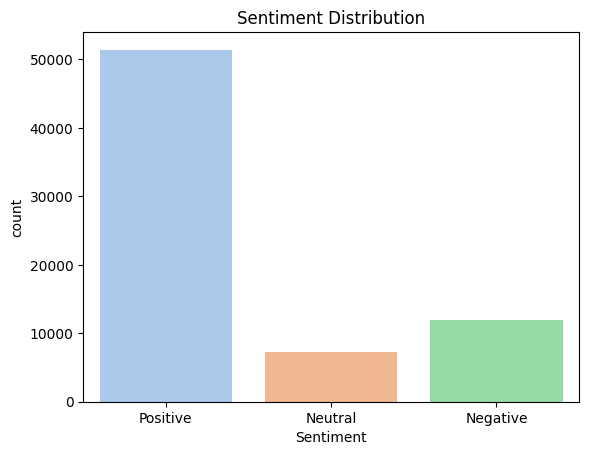

In [62]:
### Visualize customer sentiments

sns.countplot(data=df, x= 'Sentiment', palette= 'pastel')
plt.title('Sentiment Distribution')
plt.show()


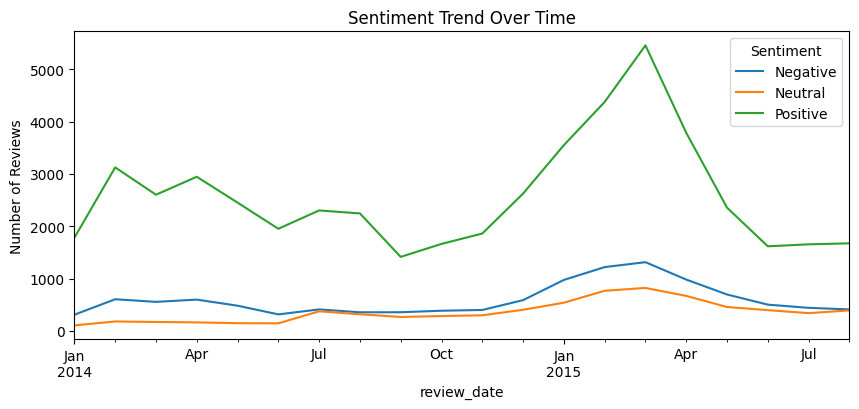

In [63]:
## Time series Sentiments analysis

sentiment_trend = df.groupby([df['review_date'].dt.to_period('M'),'Sentiment']).size().unstack()
sentiment_trend.plot(figsize=(10,4))
plt.title('Sentiment Trend Over Time')
plt.ylabel('Number of Reviews')
plt.show()

In [64]:
### Generating Net Promoter Score

df['nps_type'] = df['star_rating'].apply(lambda x: 'promoter' if x >=4 else 'passive' if x==2 or x==3 else 'detractor')
df['nps_type'].value_counts()

,count
nps_type,
promoter,44708
detractor,16173
passive,9730


In [65]:
### Calculate NPS Percentage

nps = (len(df[df['nps_type']== 'promoter']) - len(df[df['nps_type'] == 'detractor'])) / len(df) *100
print(f'Net Promoter Score: {nps:.2f}%')

Net Promoter Score: 40.41%


In [66]:
from wordcloud import WordCloud
from collections import Counter

# Word frequency from Negative reviews
negative_reviews = df[df['Sentiment'] == 'Negative']
all_words = ''.join(negative_reviews['cleaned_review'])
wordcloud = WordCloud(stopwords=set(stopwords.words('english')), background_color='white').generate(all_words)

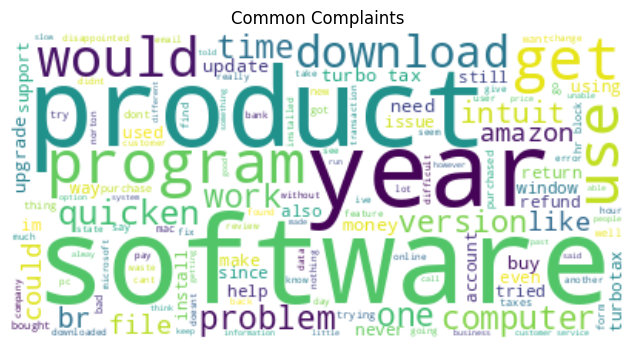

In [67]:
plt.figure(figsize=(10,4))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.title('Common Complaints')
plt.show()

In [68]:
### Extract top phrases for positive and negative reviews

from sklearn.feature_extraction.text import CountVectorizer

# def a function to vectorize our reviews

def get_top_phrases(reviews,title,color):
    vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=100)
    phrase_matrix = vectorizer.fit_transform(reviews)
    phrases = vectorizer.get_feature_names_out()
    frequencies = phrase_matrix.sum(axis=0).A1
    phrase_df = pd.DataFrame({"Phrase":phrases, "frequency": frequencies})
    phrase_df = phrase_df.sort_values(by= "frequency", ascending=False)

    # Bar plot visualization
    plt.figure(figsize=(10,8))
    sns.barplot(data=phrase_df.head(20), x= 'frequency', y= 'Phrase', palette= color)
    plt.title('title')
    plt.xlabel('frequency')
    plt.ylabel('Phrases')
    plt.show()
    return phrase_df


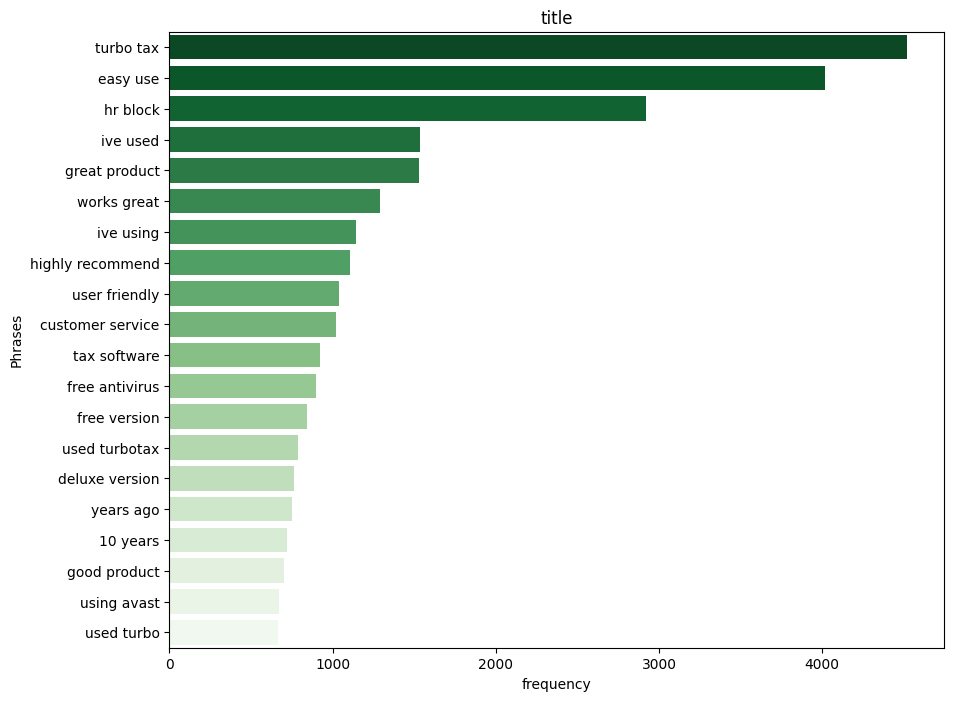

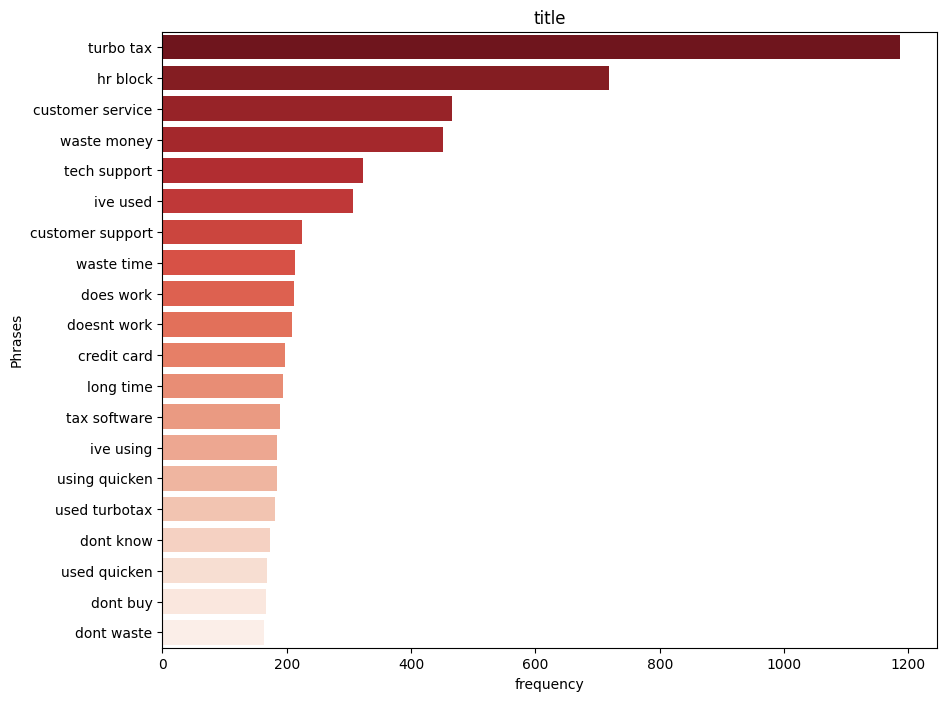

In [69]:
# Positive phrases

positive_reviews = df[df['Sentiment'] == 'Positive']['cleaned_review']
pos_df = get_top_phrases(positive_reviews, 'Top Phrases in Positive Reviews', 'Greens_r')

# Negative phrases

negative_reviews = df[df['Sentiment'] == 'Negative']['cleaned_review']
pos_df = get_top_phrases(negative_reviews, 'Top Phrases in Negative Reviews', 'Reds_r')


In [70]:
tfidf = TfidfVectorizer(max_features= 5000, stop_words='english')
X = tfidf.fit_transform(df['cleaned_review'])

In [71]:
# Topic Modelling with LDA(Latent Derichlet Allocation)

from sklearn.decomposition import LatentDirichletAllocation

# LDA Model

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display Topics
words = tfidf.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    print(f'Topic {i}:')
    print("  " + ", ".join(words[j] for j in topic.argsort()[-10:]))
    print("\n")

Topic 0:
  program, price, works, excellent, love, product, use, good, easy, great


Topic 1:
  protection, years, virus, best, works, computer, norton, antivirus, free, avast


Topic 2:
  2015, time, like, software, windows, new, mac, br, version, quicken


Topic 3:
  amazon, money, office, just, product, expected, program, software, work, download


Topic 4:
  return, software, hr, years, taxes, state, turbo, year, turbotax, tax




In [72]:
# Clustering-

## Grouping our customers based on certain traits or behavior as picked up by the model

### There are two types of clustering methods:

# Silhouette score

# r1bow method

# When clustering, it is best to reduce multidimensionality in the data.This is done by a technique called Dimensionality reduction.

# There are two methods of multidimensionality Reduction

# PCA(Principal Component Analysis)
# SVD



In [73]:
# Dimensionality Reduction and Clustering

from sklearn.decomposition import PCA
from sklearn.cluster   import KMeans
from sklearn.metrics  import silhouette_score
from sklearn.preprocessing import  StandardScaler

#Dimensionality
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X.toarray())




In [74]:
# Find the optimal K using silhoutte score

scores = []
for k in range(2,10):
    kmeans = KMeans(n_clusters= k, random_state=42)
    kmeans.fit(X_reduced_pca)
    score =silhouette_score(X_reduced_pca,kmeans.labels_)
    scores.append(score)
    print(f"Silhoutte Score for K={k}: {score}")

Silhoutte Score for K=2: 0.7925818797405016
Silhoutte Score for K=3: 0.8162725150628409
Silhoutte Score for K=4: 0.7044857935261349
Silhoutte Score for K=5: 0.7264388775900822
Silhoutte Score for K=6: 0.6924338298642694
Silhoutte Score for K=7: 0.6835160574191653
Silhoutte Score for K=8: 0.42847608613804206
Silhoutte Score for K=9: 0.45268849122253135


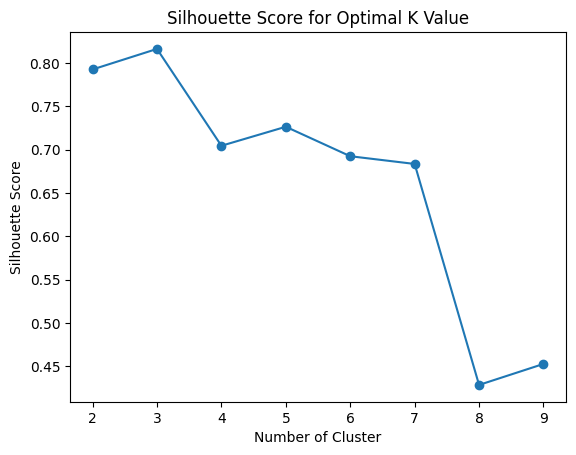

In [75]:
# Visualize the outcome of silhouette score


plt.plot(range(2,10), scores, marker= 'o')
plt.title('Silhouette Score for Optimal K Value')
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

In [76]:
# Create a new column for your data based on Optimal K value of 3

kmeans = KMeans(n_clusters = 3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_reduced_pca)


In [77]:
df[['customer_id', 'Sentiment', 'cluster']].head(10)

,customer_id,Sentiment,cluster
0,17747349,Positive,2
1,10956619,Positive,0
2,13132245,Neutral,0
3,35717248,Negative,0
4,17710652,Positive,0
5,42392705,Positive,0
6,52845868,Negative,0
7,15696503,Negative,0
8,9723928,Negative,0
9,23522877,Positive,0


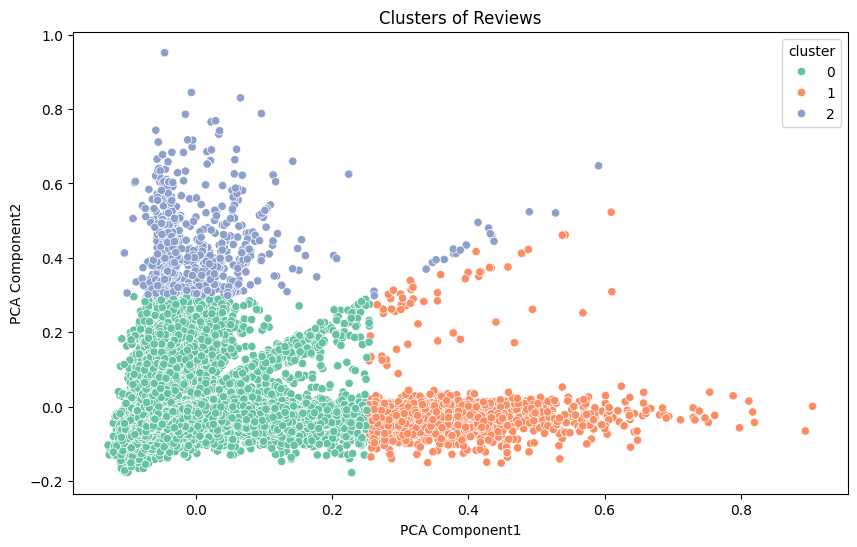

In [80]:
# Visualize our clusters

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_reduced_pca[:, 0],y=X_reduced_pca[:, 1], hue=df['cluster'], palette= 'Set2')
plt.title('Clusters of Reviews')
plt.xlabel('PCA Component1')
plt.ylabel('PCA Component2')
plt.show()

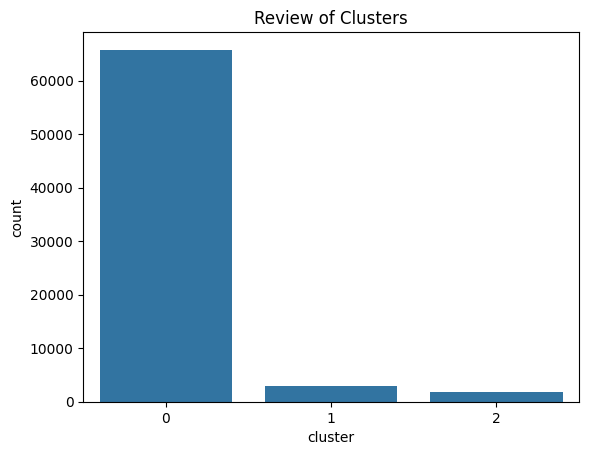

In [81]:
# Countplot of Clusters

import seaborn as sns
sns.countplot(x='cluster', data= df)
plt.title('Review of Clusters')
plt.show()

In [83]:
# Apply oversampling and supervised machine learning algorithm to predict user rating


X = tfidf.transform(df['cleaned_review'])
Y = df['star_rating']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2, random_state=42,stratify=Y)

In [84]:
# Oversample the data due to sample imbalance


from imblearn.over_sampling import RandomOverSampler



ros = RandomOverSampler(random_state=42)
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train, Y_train)


print('Original Class Distribution', Counter(Y_train))
print('Resampled Class Distribution', Counter(Y_train_resampled))


Original Class Distribution Counter({5.0: 26938, 1.0: 12938, 4.0: 8828, 3.0: 4316, 2.0: 3468})
Resampled Class Distribution Counter({5.0: 26938, 1.0: 26938, 3.0: 26938, 4.0: 26938, 2.0: 26938})


In [87]:
# Model Training

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, Y_train_resampled)


y_pred = model.predict(X_test)
print("Classification Report: \n", classification_report(Y_test, y_pred))




Classification Report: 
               precision    recall  f1-score   support

         1.0       0.72      0.65      0.69      3235
         2.0       0.18      0.30      0.22       867
         3.0       0.21      0.34      0.26      1079
         4.0       0.30      0.36      0.33      2207
         5.0       0.84      0.68      0.75      6735

    accuracy                           0.57     14123
   macro avg       0.45      0.46      0.45     14123
weighted avg       0.64      0.57      0.60     14123

